In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import f1_score
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, GaussianNoise, Input, Rescaling
from tensorflow.keras.regularizers import L2, L1
from tensorflow.keras.callbacks import ModelCheckpoint

2025-06-08 05:46:21.890177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749361582.082733      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749361582.139221      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
dataset = np.load(r"/kaggle/input/pneumoniamnist/pneumoniamnist.npz")
dataset["train_images"].shape, dataset["train_labels"].shape

((3882, 28, 28), (3882, 1))

In [3]:
def normalization(image_set):
    min_val = np.min(image_set)
    max_val = np.max(image_set)
    difference = max_val - min_val
    return (image_set - min_val) / difference

In [4]:
xtrain = normalization(dataset["train_images"].reshape(-1, 28, 28, 1))
ytrain = dataset["train_labels"]

xvalid = normalization(dataset["val_images"].reshape(-1, 28, 28, 1))
yvalid = dataset["val_labels"]

xtest  = normalization(dataset["test_images"].reshape(-1, 28, 28, 1))
ytest = dataset["test_labels"]

Train Class Distribution:
Class 0: 388 samples
Class 1: 3494 samples

Validation Class Distribution:
Class 0: 135 samples
Class 1: 389 samples

Test Class Distribution:
Class 0: 234 samples
Class 1: 390 samples


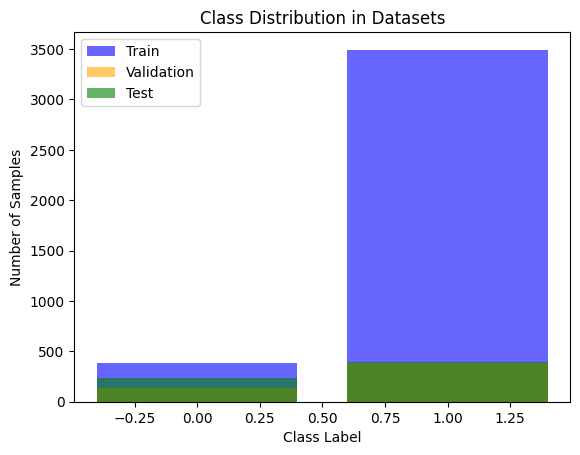

In [5]:
unique_train, counts_train = np.unique(ytrain, return_counts=True)
unique_val, counts_val = np.unique(yvalid, return_counts=True)
unique_test, counts_test = np.unique(ytest, return_counts=True)

# Print distribution
print("Train Class Distribution:")
for cls, count in zip(unique_train, counts_train):
    print(f"Class {cls}: {count} samples")

print("\nValidation Class Distribution:")
for cls, count in zip(unique_val, counts_val):
    print(f"Class {cls}: {count} samples")

print("\nTest Class Distribution:")
for cls, count in zip(unique_test, counts_test):
    print(f"Class {cls}: {count} samples")

# Optional: visualize imbalance
plt.bar(unique_train, counts_train, color='blue', alpha=0.6, label='Train')
plt.bar(unique_val, counts_val, color='orange', alpha=0.6, label='Validation')
plt.bar(unique_test, counts_test, color='green', alpha=0.6, label='Test')
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.legend()
plt.title("Class Distribution in Datasets")
plt.show()


In [6]:
data_augmentation = Sequential([
    Input(shape=(28, 28, 1)),          
    RandomFlip("horizontal"),
    RandomRotation(0.1),                    # Rotate by ±10%
    RandomZoom(0.1),
    RandomTranslation(0.1, 0.1),
    GaussianNoise(0.1),                     # Add noise
])

AUTOTUNE = tf.data.AUTOTUNE

# Convert to tf.data.Dataset
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
train_ds = train_ds.shuffle(buffer_size=1024).map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(64).prefetch(AUTOTUNE)

# Validation and test datasets (without augmentation)
val_ds = tf.data.Dataset.from_tensor_slices((xvalid, yvalid)).batch(64).prefetch(AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((xtest, ytest)).batch(64).prefetch(AUTOTUNE)


I0000 00:00:1749361597.643882      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
input_shape = (28, 28, 1)
input_layer = Input(shape=input_shape)

x = Concatenate()([input_layer, input_layer, input_layer])

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
base_model.trainable = False

weight_reg = L2(1e-4)   # L2 for weights
bias_reg = L1(1e-6)     # L1 for biases

# Modified model head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.03)(x)
x = Dense(128, activation='relu',
          kernel_regularizer=weight_reg,
          bias_regularizer=bias_reg)(x)
x = Dropout(0.03)(x)
output = Dense(1, activation='sigmoid',
               kernel_regularizer=weight_reg,
               bias_regularizer=bias_reg)(x)

model = Model(inputs=input_layer, outputs=output)

model.summary()
              

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 28, 28, 3)      │              0 │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_1[0][0],   │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 34, 34, 3)      │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 14, 14, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 14, 14, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 14, 14, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 16, 16, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 7, 7, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 7, 7, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 7, 7, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
def binary_focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # avoid log(0)
        bce = - (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        loss = alpha_factor * modulating_factor * bce
        return tf.reduce_mean(loss)
    return focal_loss

class BalancedAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='balanced_accuracy', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.tn = self.add_weight(name='tn', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        tn = tf.reduce_sum((1 - y_true) * (1 - y_pred))
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.tp.assign_add(tp)
        self.tn.assign_add(tn)
        self.fp.assign_add(fp)
        self.fn.assign_add(fn)

    def result(self):
        recall = self.tp / (self.tp + self.fn + 1e-7)
        specificity = self.tn / (self.tn + self.fp + 1e-7)
        return (recall + specificity) / 2

    def reset_states(self):
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)



class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.threshold = threshold
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        tp = tf.reduce_sum(y_true * y_pred)
        fp = tf.reduce_sum((1 - y_true) * y_pred)
        fn = tf.reduce_sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-7)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-7)
        return 2 * (precision * recall) / (precision + recall + 1e-7)

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)



In [9]:
checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Callback to restore best weights after training
restore_best_weights = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)


In [10]:

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,      # number of steps after which decay is applied
    decay_rate=0.96,        # decay rate
    staircase=True          # if True, learning rate decays in discrete steps
)


model.compile(
    tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=binary_focal_loss(gamma=2.0, alpha=0.25),
    metrics=[
        BalancedAccuracy(name='balanced_accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        F1Score(name='f1_score')  # instance of the class
    ]
)

history = model.fit(
    xtrain, ytrain,
    validation_data=(xvalid, yvalid),
    epochs=1000,
    verbose=1,
    callbacks=[checkpoint, restore_best_weights]
)


Epoch 1/1000


I0000 00:00:1749361615.425165      57 service.cc:148] XLA service 0x7d349c001930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749361615.425700      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749361617.053813      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


 18/122 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.5014 - balanced_accuracy: 0.4685 - f1_score: 0.8822 - loss: 0.0699

I0000 00:00:1749361621.075185      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - auc: 0.6712 - balanced_accuracy: 0.5796 - f1_score: 0.9040 - loss: 0.0534
Epoch 1: val_loss improved from inf to 0.03728, saving model to /kaggle/working/best_model.weights.h5
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 119ms/step - auc: 0.6720 - balanced_accuracy: 0.5801 - f1_score: 0.9042 - loss: 0.0533 - val_auc: 0.9415 - val_balanced_accuracy: 0.8402 - val_f1_score: 0.9147 - val_loss: 0.0373
Epoch 2/1000
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8897 - balanced_accuracy: 0.7457 - f1_score: 0.9436 - loss: 0.0287
Epoch 2: val_loss did not improve from 0.03728
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8897 - balanced_accuracy: 0.7458 - f1_score: 0.9436 - loss: 0.0287 - val_auc: 0.9511 - val_balanced_accuracy: 0.8213 - val_f1_score: 0.9252 - val_loss: 0.0375
Epoch 3/1000
121/122 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9104 - balanced_accuracy: 0.8015 - f1_score: 0.9479 - loss: 0.0264
Epoch 3: val_loss improved from 0.03728 to 0.03491,

Test Loss: 0.0532
Test Balanced Accuracy: 0.8410
Test AUC: 0.9292
Test F1-Score: 0.8936


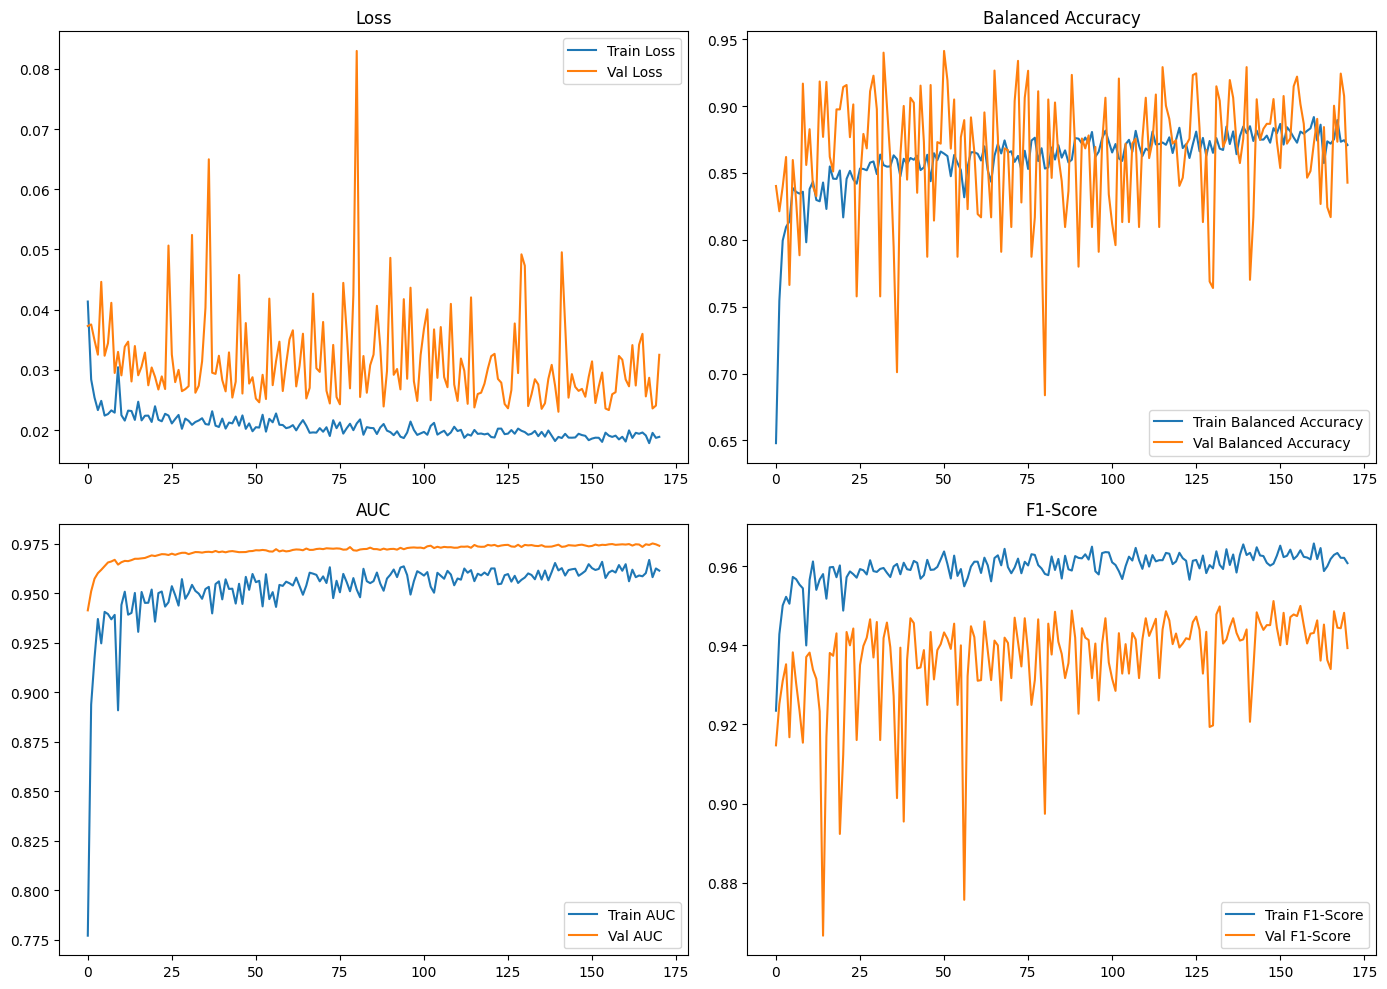

In [11]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['balanced_accuracy'], label='Train Balanced Accuracy')
    plt.plot(history.history['val_balanced_accuracy'], label='Val Balanced Accuracy')
    plt.legend()
    plt.title('Balanced Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.legend()
    plt.title('AUC')

    plt.subplot(2, 2, 4)
    plt.plot(history.history['f1_score'], label='Train F1-Score')
    plt.plot(history.history['val_f1_score'], label='Val F1-Score')
    plt.legend()
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

test_metrics = model.evaluate(xtest, ytest, verbose=0)

print(f"Test Loss: {test_metrics[0]:.4f}")
print(f"Test Balanced Accuracy: {test_metrics[1]:.4f}")
print(f"Test AUC: {test_metrics[2]:.4f}")
print(f"Test F1-Score: {test_metrics[3]:.4f}")


plot_metrics(history)